In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import random
import cv2
import seaborn
from pathlib import Path
from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import RMSprop

In [2]:
# DATASET PATH
img_path = '/Users/bimaaristo/Documents/Coding/POSTECH/Pill Recognition/Pill & Package Dataset' 

In [3]:
# CLASS DISTRIBUTION FUNCTION

## TRAIN
def train_class(base_path):
    # Get class names from train folder 
    train_path = os.path.join(base_path, 'train')
    class_names = sorted([d for d in os.listdir(train_path) 
                         if os.path.isdir(os.path.join(train_path, d))])
    return class_names

def train_image_paths(base_path, subset='train'):
    # Get all image paths from the specified subset (train/validation)
    subset_path = os.path.join(base_path, subset)
    image_paths = []

    for class_name in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):

            valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
            paths = [os.path.join(class_path, f) for f in os.listdir(class_path)
                    if f.lower().endswith(valid_extensions)]
            image_paths.extend(paths)
    
    return image_paths

# VALL
def val_class(base_path):
    # Get class names from validation folder 
    train_path = os.path.join(base_path, 'val')
    class_names = sorted([d for d in os.listdir(train_path) 
                         if os.path.isdir(os.path.join(train_path, d))])
    return class_names

def val_image_paths(base_path, subset='val'):
    # Get all image paths from the specified subset validation
    subset_path = os.path.join(base_path, subset)
    image_paths = []

    for class_name in os.listdir(subset_path):
        class_path = os.path.join(subset_path, class_name)
        if os.path.isdir(class_path):

            valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
            paths = [os.path.join(class_path, f) for f in os.listdir(class_path)
                    if f.lower().endswith(valid_extensions)]
            image_paths.extend(paths)
    
    return image_paths

def display_random_images(image_paths, num_images=50, cols=10):
    # Display random images
    sample_paths = random.sample(image_paths, min(num_images, len(image_paths)))
    rows = (num_images + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 2*rows))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)  
    axes = axes.flatten() if rows > 1 else [axes]
    
    for idx, (img_path, ax) in enumerate(zip(sample_paths, axes)):
        # Class Name
        class_name = Path(img_path).parent.name
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Class Name as a Title
        ax.set_title(class_name, fontsize=8, pad=2)  # Reduced padding
        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['right'].set_visible(True)
        
    for idx in range(len(sample_paths), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
def plot_training_history(history):
    # Get training history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Get number of epochs
    epochs_range = range(len(acc))
    
    # Create figure with two subplots
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend(loc='lower right')
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [5]:
# CLASS
print("Classes in the dataset:")
class_names = train_class(img_path)
for idx, class_name in enumerate(class_names, 1):
    print(f"{idx}. {class_name}")

Classes in the dataset:
1. Ascozin
2. Bioflu
3. Biogesic
4. Bonamine
5. Buscopan
6. DayZinc
7. Decolgen
8. Flanax
9. Imodium
10. Lactezin
11. Lagundi
12. Midol
13. Myra_E
14. Neurogen_E
15. Omeprazole
16. Rinityn
17. Rogin_E
18. Sinecod
19. Tempra
20. Tuseran



Val Set Images:


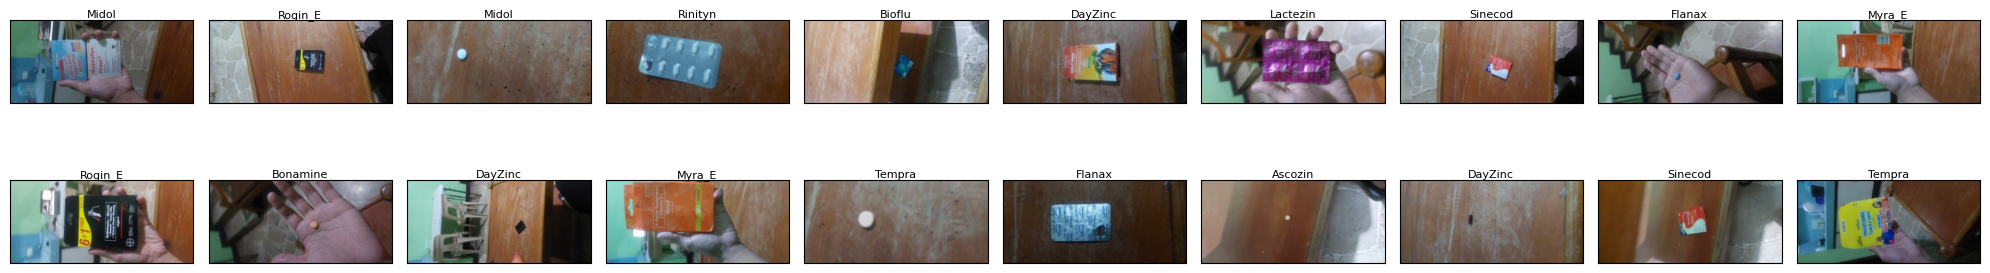

In [19]:
# DATASET
print("\nVal Set Images:")
train_paths = val_image_paths(img_path)
display_random_images(train_paths, 20)


Train Set Images:


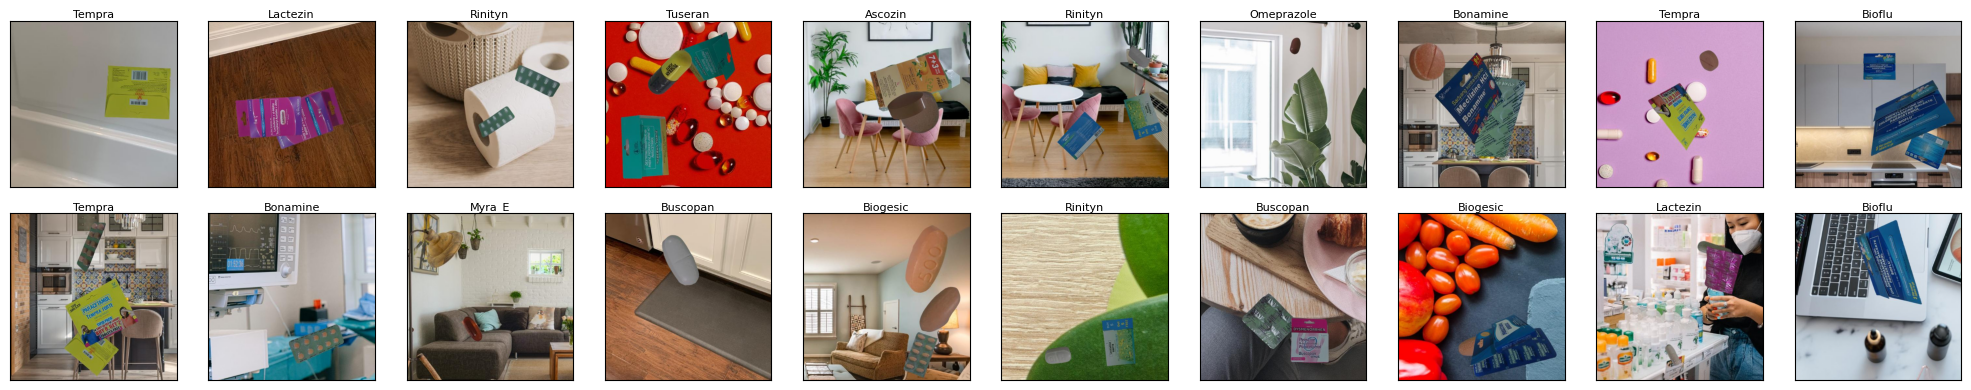

In [20]:
# DATASET
print("\nTrain Set Images:")
train_paths = train_image_paths(img_path)
display_random_images(train_paths, 20)

In [6]:
# PATH
train_path = '/Users/bimaaristo/Documents/Coding/POSTECH/Pill Recognition/Pill & Package Dataset/Train'
val_path = '/Users/bimaaristo/Documents/Coding/POSTECH/Pill Recognition/Pill & Package Dataset/Val'
# AUGMENTATION
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 20,      
    width_shift_range = 0.1,   
    height_shift_range = 0.1,  
    shear_range = 0.1,        
    zoom_range = 0.1,         
    horizontal_flip = True,
    vertical_flip = False,      
    brightness_range=[0.8,1.2], 
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale = 1./255.  
)

# Flow from directory
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150,150),
    batch_size=32,     
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(150,150),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False    
)


Found 40000 images belonging to 20 classes.
Found 9103 images belonging to 20 classes.


In [22]:
# CNN BASED MODEL
model = tf.keras.models.Sequential([
    # 1ST
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(150, 150, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # 2ND
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # 3RD
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    # Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(20, activation='softmax')
])
# Regulizer
for layer in model.layers:
    if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.Dense)):
        layer.kernel_regularizer = tf.keras.regularizers.l2(0.01)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_4 (Bat  (None, 150, 150, 32)      128       
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 75, 75, 64)       

In [23]:
"""# LR Scheduler
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)"""

'# LR Scheduler\ninitial_learning_rate = 0.001\ndecay_steps = 1000\ndecay_rate = 0.9\n\nlr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(\n    initial_learning_rate,\n    decay_steps=decay_steps,\n    decay_rate=decay_rate,\n    staircase=True\n)'

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20, 
    verbose=1
)

Epoch 1/20


2024-11-05 22:38:42.488334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - ETA: 0s - loss: 2.6421 - accuracy: 0.2173

2024-11-05 22:40:58.816519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 143s 113ms/step - loss: 2.6421 - accuracy: 0.2173 - val_loss: 2.8957 - val_accuracy: 0.1989
Epoch 2/20
1250/1250 [==============================] - 138s 110ms/step - loss: 1.8446 - accuracy: 0.4301 - val_loss: 2.6138 - val_accuracy: 0.2498
Epoch 3/20
1250/1250 [==============================] - 155s 123ms/step - loss: 1.4068 - accuracy: 0.5704 - val_loss: 3.6127 - val_accuracy: 0.1471
Epoch 4/20
1250/1250 [==============================] - 143s 114ms/step - loss: 1.0994 - accuracy: 0.6618 - val_loss: 3.5234 - val_accuracy: 0.1826
Epoch 5/20
1250/1250 [==============================] - 138s 111ms/step - loss: 0.9048 - accuracy: 0.7213 - val_loss: 3.1912 - val_accuracy: 0.1872
Epoch 6/20
1250/1250 [==============================] - 140s 112ms/step - loss: 0.7894 - accuracy: 0.7566 - val_loss: 3.1565 - val_accuracy: 0.2151
Epoch 7/20
1250/1250 [==============================] - 148s 119ms/step - loss: 0.7155 - accuracy: 0.7775 - val_loss: 3.217

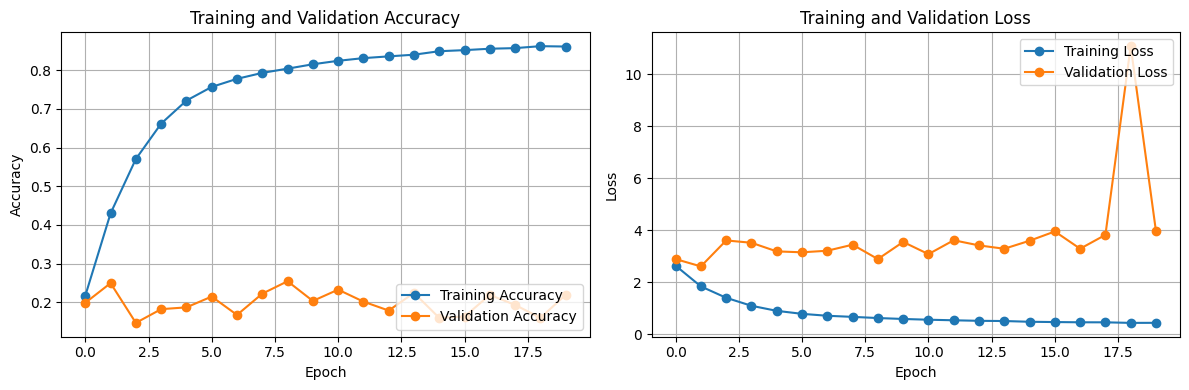

In [26]:
# Call the function after training
plot_training_history(history)

In [27]:
# 1. Save entire model (architecture + weights + optimizer state)
model.save('complete_model.h5')
# 2. Save only model weights
model.save_weights('model_weights.h5')
# 3. Save in TensorFlow SavedModel format
model.save('saved_model')

# To save with date and accuracy info
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
val_acc = history.history['val_accuracy'][-1]  # Get last validation accuracy
model_name = f'model_{current_time}_val_acc_{val_acc:.3f}.h5'
model.save(model_name)
print(f"Model saved as: {model_name}")

/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets
/opt/anaconda3/envs/datascience/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as: model_20241105_234035_val_acc_0.219.h5
